##**Plan Stage**
###**Business Deliverables**
1.   **Problem:** Salifort Motors is experiencing a high turnover rate, and they want to understand why employees are leaving the company.
2. **Goal:** To develop a predictive model that can predict which employees are at risk of leaving the company, and to identify the reasons behind their departure.
3.**Deliverables:**
A predictive model that can predict which employees are at risk of leaving the company.
A report that identifies the reasons behind employee departures.
A presentation that summarizes the findings and recommendations.

In the beginning, all the required packages are imported.

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

In [2]:
# importing the data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
import io

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/HR_comma_sep.csv')

In [4]:
#glimpse of the dataset
df.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


###**Data Cleaning**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [6]:
#checking for missing values
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

**We can see that there are no missing values in the dataset**

In [7]:
df.duplicated().sum()

3008

**Almost 20% of the data is duplicated. With that percentage, the dataset needs to be examined before dropping them.**

In [8]:
df[df.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


**After examing the data , it doesnt seem legitimate and is considered an unintentional. Hence dropping them**

In [9]:
df1 = df.drop_duplicates(keep='first')

In [10]:
df1.shape

(11991, 10)

**Now check for outliers using box plot.**

<Axes: xlabel='average_montly_hours'>

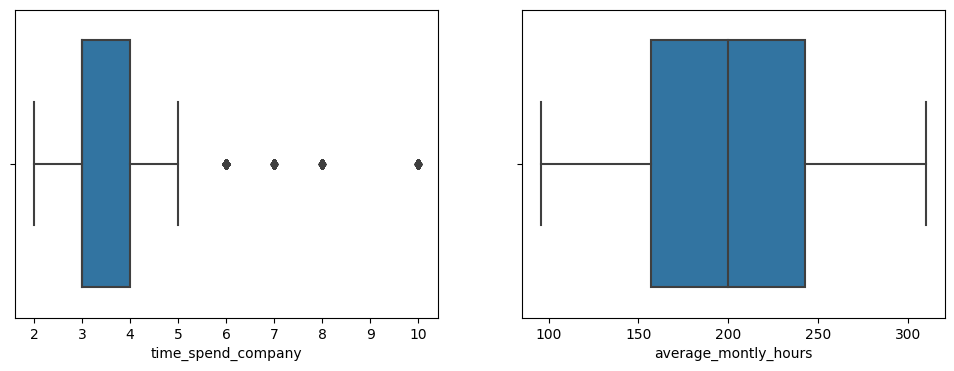

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df1['time_spend_company'], ax=axes[0])
sns.boxplot(x=df1['average_montly_hours'], ax=axes[1])

**There are no outliers in average_monthly_hours. But there are considerable outliers present for the time_spend_company. Examining the time_spend_company column**

In [12]:
def detect_outliers(data):
    # Calculate the IQR
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1

    # Calculate the lower and upper bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = [x for x in data if x < lower_bound or x > upper_bound]

    return outliers,lower_bound,upper_bound

In [13]:
outliers,lower_bound,upper_bound=detect_outliers(df1['time_spend_company'])
print("No of outliers",len(outliers))
print("lower bound",lower_bound)
print("upper bound",upper_bound)

No of outliers 824
lower bound 1.5
upper bound 5.5


**The outliers will be dealt with when the model is build**

In [14]:
df1.to_csv('/content/gdrive/MyDrive/HR_updated.csv')

##**Analyze Stage**
### **Exploratory Data Analysis**
**In this phase, the relation among the different variables are examined using python and Tableau.**

In [15]:
df1.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


Text(0.5, 1.0, 'Number of projects histogram')

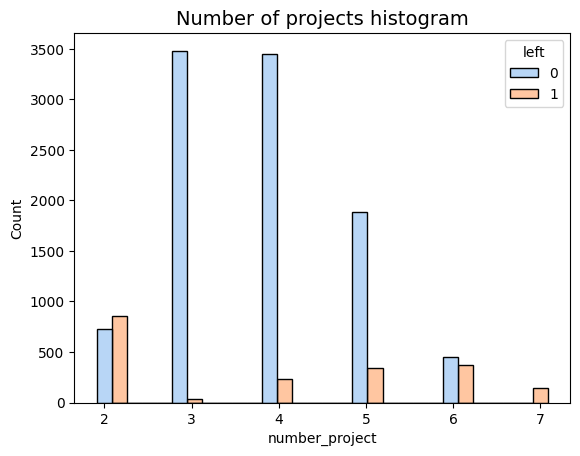

In [16]:
# pro_stay = df1[df1['left']==0]['number_project']
# pro_left = df1[df1['left']==1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2,palette='pastel')
plt.title('Number of projects histogram', fontsize='14')

**It is observed that employees with least number of projects and the most number of projects tend to leave the job more than any other. Some possible reasons maybe:**


*   Employees with the **least number of projects** may feel underutilized or bored. They may not be challenged or given enough opportunities to grow and develop their skills. This can lead to frustration and a desire to find a new job where they can be more engaged.
*   Employees with the **most number of projects** may feel overwhelmed or stressed. They may be working long hours and not have enough time to complete their work effectively. This can lead to burnout and a desire to find a job with a more manageable workload.

**The optimal number of projects for employees should be 3-5.**

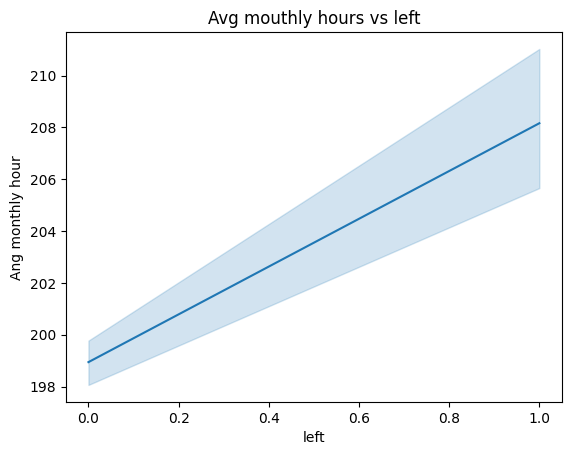

In [17]:
sns.lineplot(y=df1['average_montly_hours'], x=df1['left'])

# Add a title and labels to the axes
plt.title("Avg mouthly hours vs left")
plt.xlabel("left")
plt.ylabel("Ang monthly hour")

# Show the plot
plt.show()

**Yes, there is a correlation between the number of average monthly working hours and the likelihood of an employee leaving their job. It seems that people are leaving the job due to overworking.**

**If you assume a work week of 40 hours and two weeks of vacation per year, then the average number of working hours per month of employees working Monday–Friday = 50 weeks X 40 hours per week / 12 months = 166.67 hours per month ***

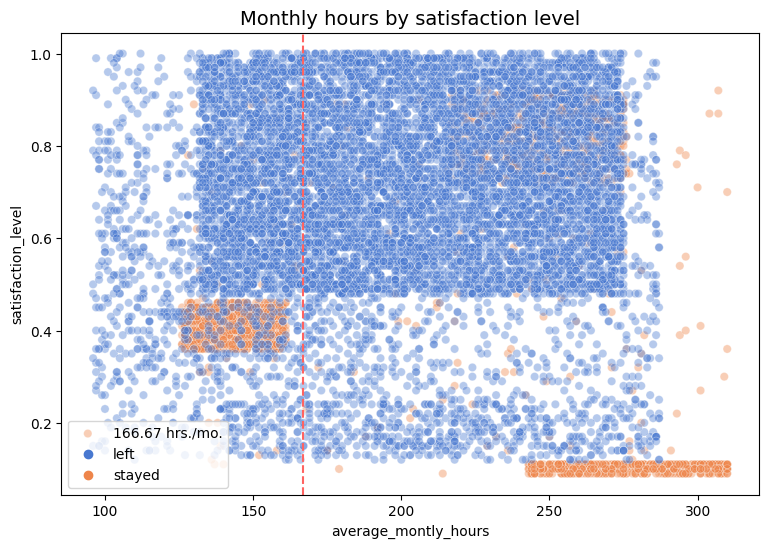

In [18]:
plt.figure(figsize=(9, 6))
sns.scatterplot(x=df1['average_montly_hours'], y=df1['satisfaction_level'], hue=df1['left'], alpha=0.4, palette='muted')
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by satisfaction level', fontsize='14');

**From the above graph it is observed that there are 3 categories of people:**

*   The people working avg 250-300 hrs/month, they are very less satisfied and hence leaving their job
*   The people although working very less like 120-150 hrs/month are also less satisfied maybe due to peer pressure are leaving their job
*   The people in the range between are not leaving their job and are considerably satidfied.

<Axes: xlabel='time_spend_company', ylabel='Count'>

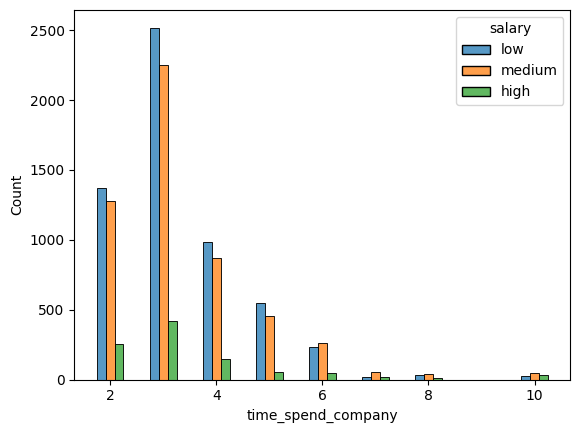

In [19]:
sns.histplot(x=df1['time_spend_company'], hue=df1['salary'], discrete=1,
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5)

**This suggests that long-tenured employees are not disproportionately comprised of higher-paid employees.**

There are a few possible explanations for this. First, it is possible that the company has a pay structure that is not based on tenure. In this case, all employees, regardless of their tenure, would be paid the same amount.

Second, it is possible that the company has a pay structure that is based on performance. In this case, employees who are more productive would be paid more, regardless of their tenure.

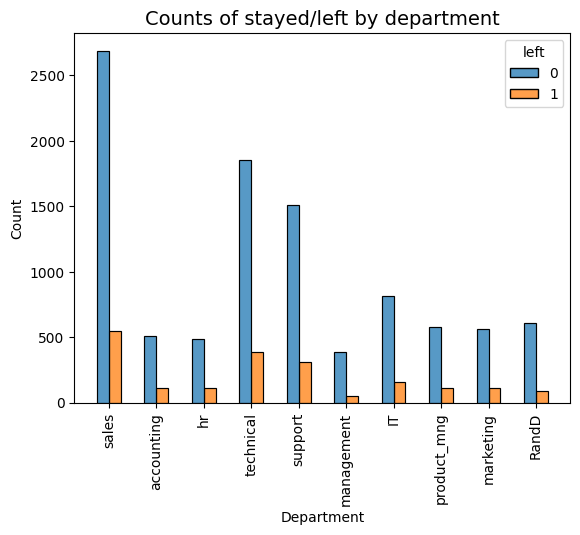

In [20]:
sns.histplot(x=df1['Department'], hue=df1['left'], discrete=1,
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation='vertical')
plt.title('Counts of stayed/left by department', fontsize=14);

**There doesn't seem to be any department that differs significantly in its proportion of employees who left to those who stayed.**

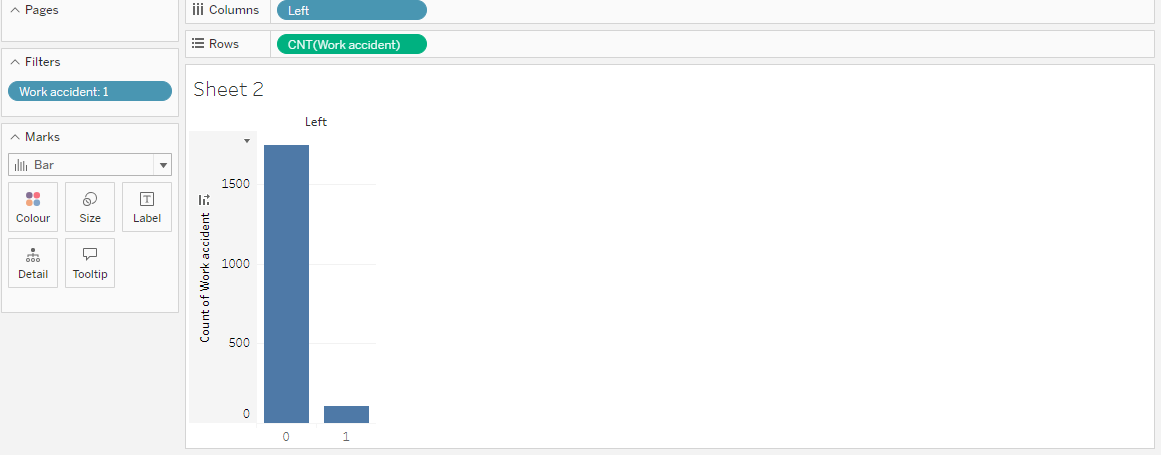

There are a few possible explanations for this. First, it is possible that long-tenured employees are more likely to be exposed to hazards in the workplace. They may be working with more dangerous equipment or in more hazardous environments.

Second, it is possible that long-tenured employees may be less likely to report accidents. They may feel like they have to "tough it out" or that they will be seen as weak if they report an accident.

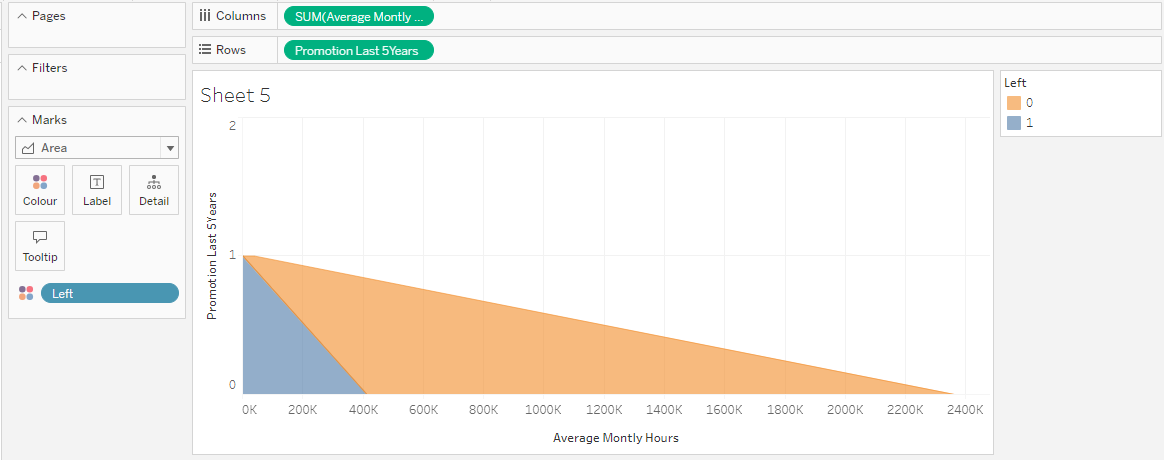

 First, working long hours can lead to burnout, which can make employees feel stressed, exhausted, and unmotivated. This can make them more likely to look for a new job that offers a better work-life balance with 1 promotion

<ipython-input-21-5115092ab70a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df1.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))


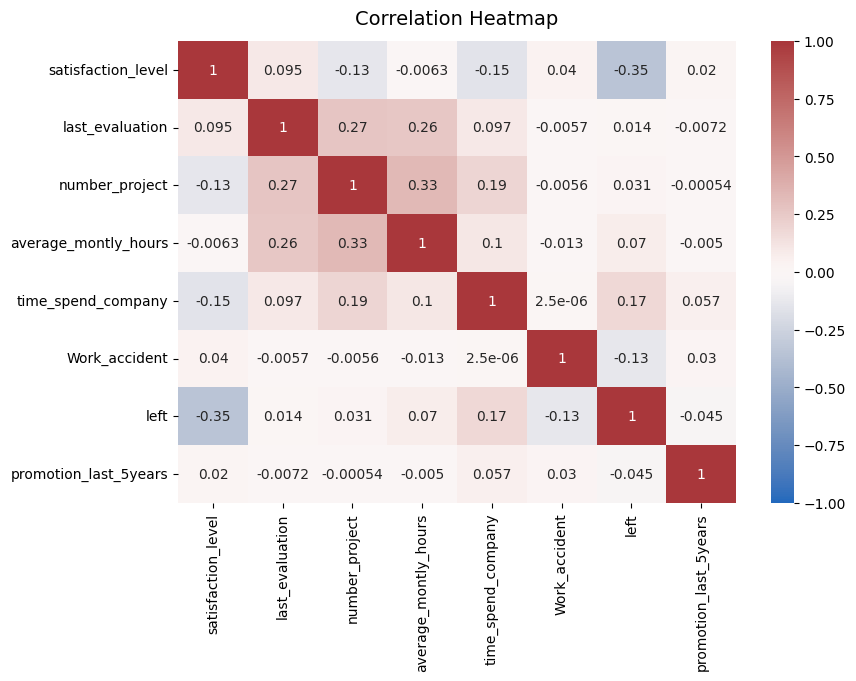

In [21]:
plt.figure(figsize=(9,6))
heatmap = sns.heatmap(df1.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

##**Construct Phase**
###*Since* the variable to predict (whether an employee leaves the company) is categorical, Tree-based Machine Learning model can be used. Since it is binary classification problem , Logistic Regression can also be used.

**For logistic Regression, we need One-hot Encoding of categorical variables and check multicollinearing, outliers.**

In [23]:
df2=pd.get_dummies(df1,columns=['Department','salary'],drop_first=True)
df2.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


**Now to check multicollinearity we find how the variables are related to each other using heatmap:**

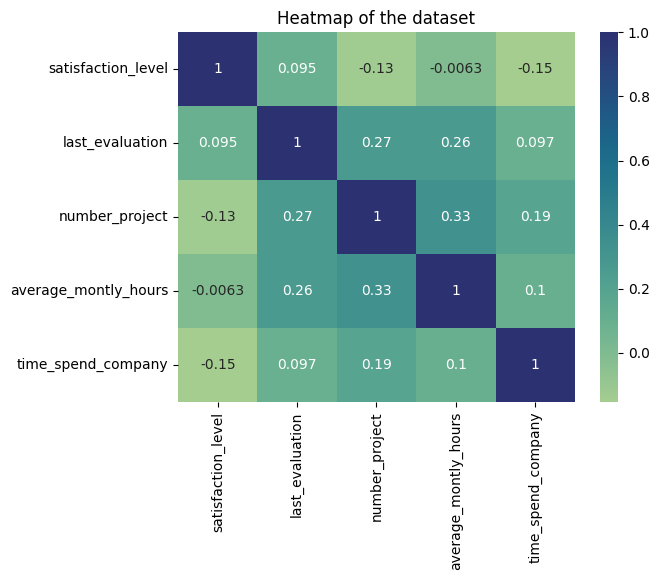

In [25]:
sns.heatmap(df2[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']].corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

**We find the variables have no multicollinearity , hence we can apply Logistic Regression easily.**

We know Logistic Regression cannot handle outliers, hence we need to remove them for better prediction.

In [26]:
df_log = df2[(df2['time_spend_company'] >= lower_bound) & (df2['time_spend_company'] <= upper_bound)]

df_log.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
5,0.41,0.50,2,153,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [27]:
df_log.shape

(11167, 19)

Now to apply the Logistic Regression model, the target and feature variables are separeted.

In [28]:
Y=df_log['left']
X=df_log.drop(columns=['left'])

In [29]:
X.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0.11,0.88,7,272,4,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,1,0,0,1,0
5,0.41,0.50,2,153,3,0,0,0,0,0,0,0,0,1,0,0,1,0


In [30]:
#Splitting training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [31]:
log_model = LogisticRegression(random_state=42, max_iter=500)

In [32]:
#fitting the data
log_model.fit(X_train,Y_train)

LogisticRegression(max_iter=500, random_state=42)

In [33]:
Y_pred=log_model.predict(X_test)

Being a classification problem, the best metrics to see results is confusion matrix

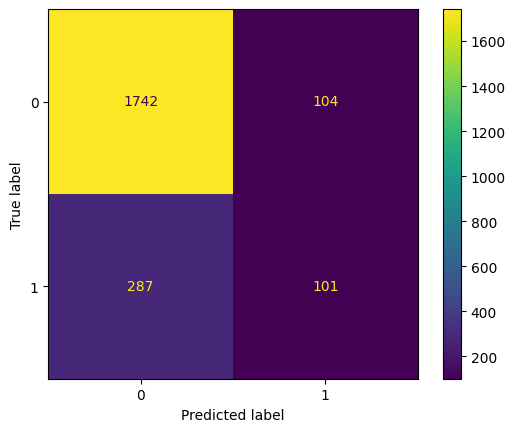

In [34]:
log_cm = confusion_matrix(Y_test, Y_pred, labels=log_model.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_model.classes_)

log_disp.plot()

plt.show()

**The low values of false positives and false negatives indicate that the model is performing well.**

False positives are instances where the model incorrectly predicts that something is positive when it is actually negative.

False negatives are instances where the model incorrectly predicts that something is negative when it is actually positive.

Lets see the value of other metrics

In [71]:
log_result=classification_report(Y_test, Y_pred)
print(log_result)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1846
           1       0.49      0.26      0.34       388

    accuracy                           0.82      2234
   macro avg       0.68      0.60      0.62      2234
weighted avg       0.80      0.82      0.80      2234



**The above are the scores for the Logistic Regression model. As the scores for True positives are less, the next model i.e the tree based algorithm is used.**

In [36]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

X_tr, X_val, y_tr, y_val = train_test_split(X_train1, Y_train1, test_size=0.25, stratify=Y_train1, random_state=0)

**The training data is further divided for validation data.**

In [45]:
tree_model=DecisionTreeClassifier(random_state=0)
param={'max_depth':[2,4, 6, 8, None],
      'min_samples_leaf': [2, 5, 1, 4],
      'min_samples_split': [2, 4, 6, 8]
      }
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

In [50]:
tree1 = GridSearchCV(tree_model, param, scoring=scoring, cv=4, refit='roc_auc')

In [51]:
%%time
tree1.fit(X_tr, y_tr)

CPU times: user 8.68 s, sys: 592 µs, total: 8.68 s
Wall time: 8.78 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [2, 4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1, 4],
                         'min_samples_split': [2, 4, 6, 8]},
             refit='roc_auc',
             scoring={'recall', 'precision', 'f1', 'roc_auc', 'accuracy'})

In [52]:
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [53]:
tree1.best_score_

0.9719174276014144

**The AUC score is very good, thus the model can predict the true positives very well.**

In [54]:
def make_results(model_name:str, model_object, metric:str):
    metric_dict = {'auc': 'mean_test_roc_auc',
                 'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }
    cv_results = pd.DataFrame(model_object.cv_results_)

    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                        'AUC': auc,
                        'Precision': precision,
                        'Recall': recall,
                        'F1': f1,
                        'Accuracy': accuracy,
                        },
                        ignore_index=True
                       )

    return table

In [55]:
tree1_results = make_results('decision tree cv', tree1, 'auc')
tree1_results

<ipython-input-54-4c7b72382967>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


,Model,AUC,Precision,Recall,F1,Accuracy
0,decision tree cv,0.971917,0.94616,0.909628,0.927241,0.975967


The above are the scores are quite good , but tree can lead to overfitting, so we need to use random forest

In [57]:
rf = RandomForestClassifier(random_state=0)
rf_params = {'max_depth': [3,5,6, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500,400],
             }
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rf1 = GridSearchCV(rf, rf_params, scoring=scoring, cv=4, refit='roc_auc')

In [58]:
%%time
rf1.fit(X_tr, y_tr)

CPU times: user 48min 3s, sys: 6.59 s, total: 48min 10s
Wall time: 48min 28s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, 6, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500, 400]},
             refit='roc_auc',
             scoring={'recall', 'precision', 'f1', 'roc_auc', 'accuracy'})

In [63]:
path = '/content/gdrive/MyDrive/'

In [60]:
def write_pickle(path, model_object, save_as:str):
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [61]:
def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [64]:
write_pickle(path, rf1, 'hr_rf1')

In [65]:
rf1 = read_pickle(path, 'hr_rf1')

As the model takes a huge amount of time to fit, output stored in a file

In [66]:
rf1.best_score_

0.9828381775232391

In [67]:
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [72]:
rf1_results = make_results('random forest cv', rf1, 'auc')
print(rf1_results)
print(tree1_results)
print(log_result)

              Model       AUC  Precision    Recall        F1  Accuracy
0  random forest cv  0.982838   0.973619  0.909631  0.940373  0.980594
              Model       AUC  Precision    Recall        F1  Accuracy
0  decision tree cv  0.971917    0.94616  0.909628  0.927241  0.975967
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1846
           1       0.49      0.26      0.34       388

    accuracy                           0.82      2234
   macro avg       0.68      0.60      0.62      2234
weighted avg       0.80      0.82      0.80      2234



<ipython-input-54-4c7b72382967>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


###**The results of the random tree model are the best**
Next evaluating in the validation set

In [73]:
def get_scores(model_name:str, model, X_test_data, y_test_data):

    preds = model.best_estimator_.predict(X_test_data)

    auc = round(roc_auc_score(y_test_data, preds), 3)
    accuracy = round(accuracy_score(y_test_data, preds), 3)
    precision = round(precision_score(y_test_data, preds), 3)
    recall = round(recall_score(y_test_data, preds), 3)
    f1 = round(f1_score(y_test_data, preds), 3)

    table = pd.DataFrame({'model': [model_name],
                        'AUC': [auc],
                        'precision': [precision],
                        'recall': [recall],
                        'f1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [74]:
tree1_val_results = get_scores('decision tree1 val', tree1, X_val, y_val)
rf1_val_results = get_scores('random forest1 val', rf1, X_val, y_val)
all_val_results1 = [tree1_val_results, rf1_val_results]
all_val_results1 = pd.concat(all_val_results1).sort_values(by='AUC', ascending=False)
all_val_results1

,model,AUC,precision,recall,f1,accuracy
0,random forest1 val,0.953,0.972,0.912,0.941,0.981
0,decision tree1 val,0.950,0.961,0.907,0.933,0.978


**In validation set also random tree outperforms descision tree model. But as the scores are very high there may be chances of data leakage.**

In [75]:
## Feature Engineering
df_new = df1.drop('last_evaluation', axis=1)

In [77]:
df_new['overworked'] = df_new['average_montly_hours']
## Previosly saw avg is 166.
df_new['overworked'] = (df_new['overworked'] > 175).astype(int)
df_new=df_new.drop('average_montly_hours', axis=1)
df_new.head()

,satisfaction_level,number_project,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,overworked
0,0.38,2,3,0,1,0,sales,low,0
1,0.80,5,6,0,1,0,sales,medium,1
2,0.11,7,4,0,1,0,sales,medium,1
3,0.72,5,5,0,1,0,sales,low,1
4,0.37,2,3,0,1,0,sales,low,0


In [78]:
df3= pd.get_dummies(df_new)
df3.head()

,satisfaction_level,number_project,time_spend_company,Work_accident,left,promotion_last_5years,overworked,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_high,salary_low,salary_medium
0,0.38,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,5,5,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [80]:
Y2 = df3['left']
X2=df3.drop('left', axis=1)
X2.head()

,satisfaction_level,number_project,time_spend_company,Work_accident,promotion_last_5years,overworked,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_high,salary_low,salary_medium
0,0.38,2,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,5,6,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,7,4,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,5,5,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,2,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [81]:
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X2, Y2, test_size=0.2, stratify=Y2, random_state=0)

# Create train & validate data
X_tr1, X_val1, y_tr1, y_val1 = train_test_split(X_train3, Y_train3, test_size=0.25, stratify=Y_train3, random_state=0)

In [82]:
cv_params = {'max_depth': [3,5,6, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500,400],
             }
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [83]:
%%time
rf2.fit(X_tr1, y_tr1)

CPU times: user 39min 40s, sys: 6.38 s, total: 39min 46s
Wall time: 40min 2s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, 6, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500, 400]},
             refit='roc_auc',
             scoring={'recall', 'precision', 'f1', 'roc_auc', 'accuracy'})

In [84]:
write_pickle(path, rf2, 'hr_rf2')

In [85]:
rf2 = read_pickle(path, 'hr_rf2')

In [86]:
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 400}

In [87]:
rf2.best_score_

0.9766633806346133

In [90]:
rf2_val_results = get_scores('random forest2 val', rf2, X_val1, y_val1)
rf2_val_results

,model,AUC,precision,recall,f1,accuracy
0,random forest2 val,0.95,0.924,0.915,0.919,0.973


**We now notice that the metrics have dropped a little bit and it doent seem now that there will be data leakage.**

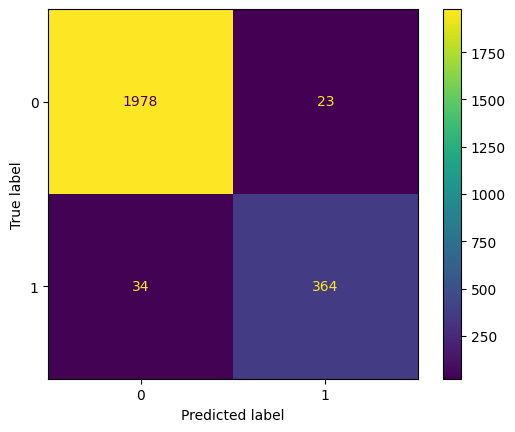

In [91]:
preds = rf2.best_estimator_.predict(X_test3)
cm = confusion_matrix(Y_test3, preds, labels=rf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot();

**The fact that the model has a higher false positive rate than false negative rate means that it is more likely to make mistakes in the direction of predicting that an employee is at risk when they are not actually at risk. However, the model is still strong overall, as it is able to correctly identify a significant number of employees who are actually at risk of quitting or getting fired.**

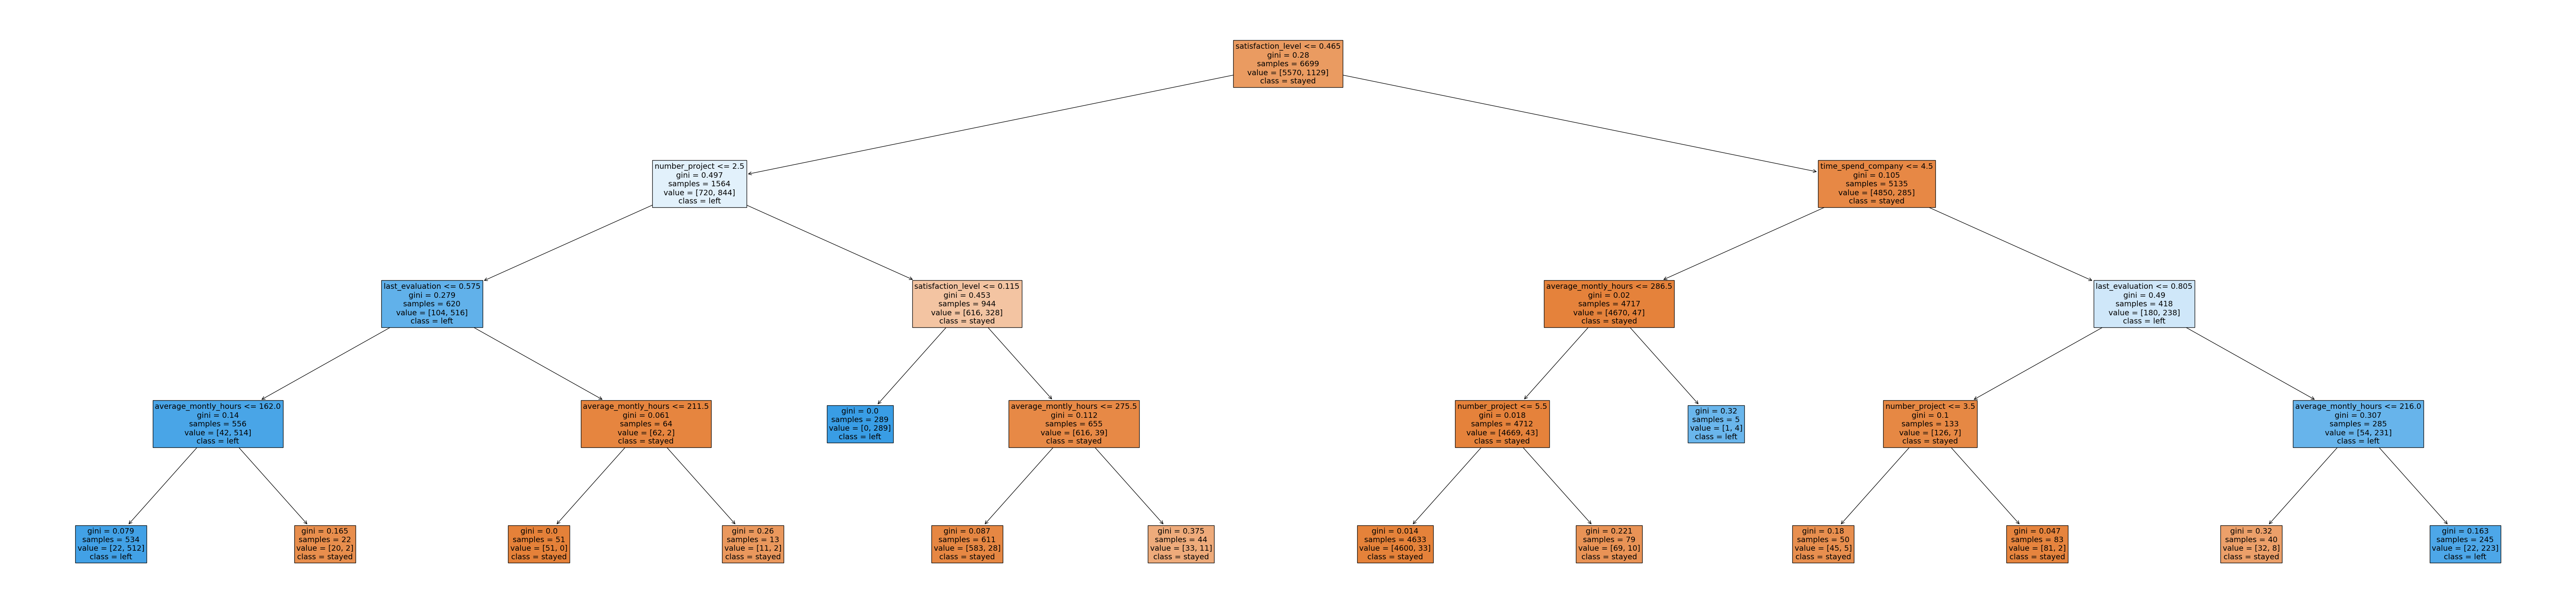

In [92]:
plt.figure(figsize=(85,20))
plot_tree(tree1.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns,
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [103]:
#Finally to conclude which features are most relevant
rftree2_importances = pd.DataFrame(rf2.best_estimator_.feature_importances_, columns=['gini_importance'],index=X2.columns)
rftree2_importances = rftree2_importances.sort_values(by='gini_importance', ascending=False)
rftree2_importances

,gini_importance
satisfaction_level,0.605824
number_project,0.208370
time_spend_company,0.144756
overworked,0.037772
Department_marketing,0.000512
salary_low,0.000426
Department_RandD,0.000376
Department_technical,0.000343
Department_IT,0.000278
Department_support,0.000213


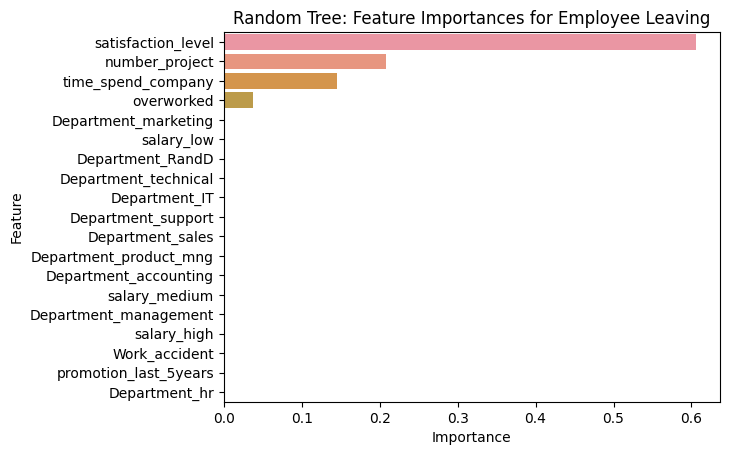

In [102]:
sns.barplot(data=rftree2_importances, x="gini_importance", y=rftree2_importances.index, orient='h')
plt.title("Random Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

**The above bar plot conclude that satisfaction_level, number_project, time_spent_company and overworked are the most influential features in predicting the value of left.**

##**Execute Phase**

###**Summary of the models**:
**Logistic Regression**:


*   Precision: 80%
*   Recall: 83%
*   F1-Score: 80%
*   accuracy: 83%

**Tree based**:

*   AUC: 95%
*   Precision: 92.4%
*   Recall: 91.5%
*   F1-Score: 91.9%
*   accuracy: 97.3%


##**Steps to be taken**

A recent analysis of employee data has revealed that employees at the company are overworked. This is a serious problem, as it can lead to employee burnout, decreased productivity, and increased turnover.


1.   Fix the number of projects that employees can work on. This will help to ensure that employees are not overloaded with work and have time to rest and recharge.
2.  Consider promoting employees who have been with the company for at least four years. This will show these employees that their hard work is appreciated and that they are valued members of the team.
3. Either reward employees for working longer hours, or don't require them to do so. If employees are not being compensated for their extra work, they are less likely to do it.
4. Provide more opportunities for employees to take breaks and vacation time. This will help employees to recharge and come back to work refreshed.
5. Offer flexible work arrangements, such as telecommuting or flextime. This will give employees more control over their work-life balance and help to reduce stress levels.
6. Provide regular feedback to employees: The company could implement a system for providing regular feedback to employees. This feedback could be given in one-on-one meetings, performance reviews, or team meetings. The feedback should be specific, constructive, and focused on helping employees improve their performance.
